In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb # type: ignore
import shap
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

#because of our business aim we decided to treat prediabetes and diabetes as one category - illness
df.loc[df['Diabetes_012']==2, 'Diabetes_012']=1

In [4]:
from sklearn.model_selection import train_test_split

y = np.array(df['Diabetes_012'])
X = df.drop(['Diabetes_012'], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, stratify=Y_val, test_size=0.3, random_state=42)

#for validation group
test_df = X_test.copy()
test_df['Diabetes_012']=Y_test.copy()

#for us to see the results
val_df = X_val.copy()
val_df['Diabetes_012']= Y_val.copy()

#for us to train
train_df = X_train.copy()
train_df['Diabetes_012']=Y_train.copy()

In [5]:
def select_K_best(k,X_t,y):
    X=X_t.copy()
    Y=y
    k_best = SelectKBest(score_func=chi2, k=k)
    fit = k_best.fit(X,Y)
    features = X.columns[fit.get_support(indices=True)].tolist()
    return X[features]

def one_hot_encoding(X):
    A=X.copy()
    encoder = OneHotEncoder(sparse_output=False)

    columns = ['Age','Income','Education']
    encoded = encoder.fit_transform(A[columns])

    one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns))
    df_encoded = pd.concat([A.reset_index(drop=True),one_hot_df.reset_index(drop=True)], axis=1)
    df_encoded = df_encoded.drop(columns, axis=1)

    return df_encoded

def change_education_to_name(Education):
    if Education in [1,2]:
        return 'PrimaryEducation'
    elif Education in [3,4]:
        return 'HighSchoolEducation'
    else:
        return 'CollageEducation' #collage not finished and bachelors degrees


def feature_binning(X):
    A= X.copy()
    A['BMI'] = pd.qcut(A['BMI'], q=10, labels=False)
    A['Age'] = pd.qcut(A['Age'], q=7 ,labels=[0,1,2,3,4,5,6])
    A['Education'] =  A['Education'].apply(change_education_to_name)
    return A



In [7]:
from sklearn.metrics import roc_auc_score

X = select_K_best(35,one_hot_encoding(feature_binning(X_train)),Y_train)
used = X.columns.to_list()
Y=Y_train
Xv = one_hot_encoding(feature_binning(X_val))[used]

model = lgb.LGBMClassifier(subsample=0.75, 
                           reg_lambda=0.5, 
                           reg_alpha=0.1, 
                           n_estimators=200, 
                           max_depth=None, 
                           learning_rate=0.05, 
                           colsample_bytree=0.75,
                           num_leaves=30,
                           bagging_freq=3,
                           bagging_fraction=0.75,
                           force_row_wise=True
                           )


model.fit(X, Y)

train_predictions = model.predict_proba(X)
Val_predictions = model.predict_proba(Xv)

auc = roc_auc_score(Y_train, train_predictions[:, 1])
print("AUC for training set:", auc)

auc = roc_auc_score(Y_val, Val_predictions[:, 1])
print("AUC for validation set:", auc)

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 27984, number of negative: 149592
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 177576, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.157589 -> initscore=-1.676279
[LightGBM] [Info] Start training from score -1.676279
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value

**Model interpretation**

In [8]:
X_sample = X.sample(n=200)
explainer = shap.Explainer(model)
shap_values = explainer(X_sample) 

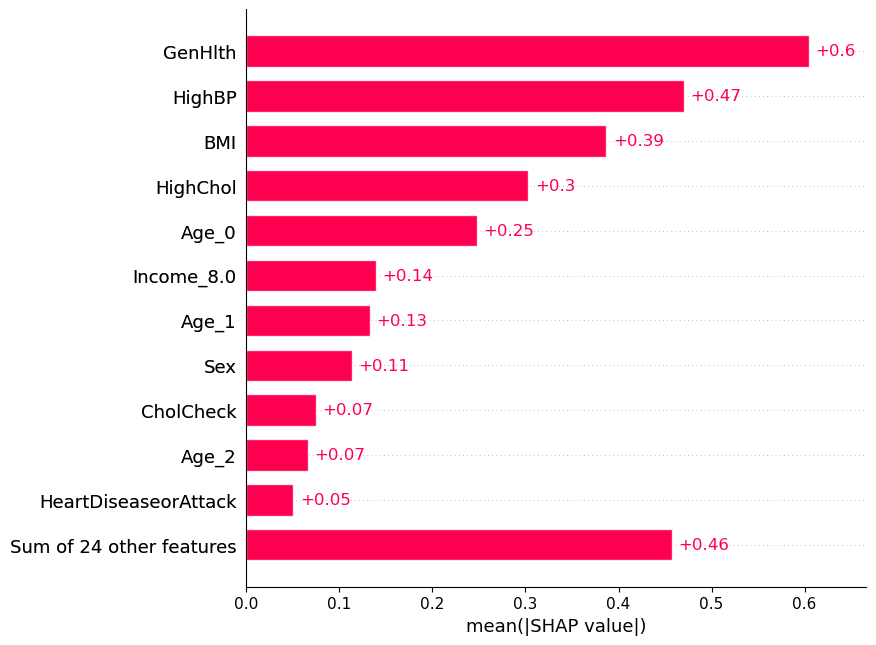

In [9]:
shap.plots.bar(shap_values,max_display=12)

The most relevant features for the model are GeneralHealth, BMI, HighChol etc

In [10]:
def detect_patient_with_positive_prediction():
    wektor = model.predict_proba(X_sample)[:,1]
    max_probab = 0
    patient=0
    for i in range(len(wektor)):
        if(wektor[i])>max_probab:
            max_probab=wektor[i]
            patient=i
    print(max_probab, patient)
    return patient

In [11]:
detect_patient_with_positive_prediction()

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.729023663602564 95


95

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.729023663602564 95
[0.27097634 0.72902366]
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.729023663602564 95


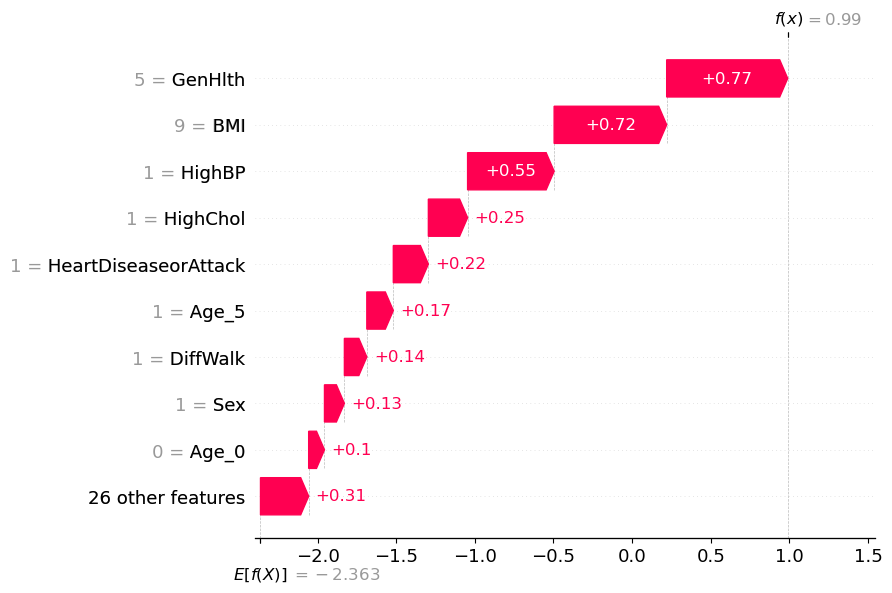

In [12]:
print(model.predict_proba(X_sample)[detect_patient_with_positive_prediction()])
shap.waterfall_plot(shap_values[detect_patient_with_positive_prediction()])

Interpretation of results may be different because we take a random sample everytime, but pink color with + sign indicate that this feature increases the risk of diabetes for patient X and on blue color with - sign represents the features that decrease the risk

In [23]:
def detect_patient_with_negative_prediction():
    wektor = model.predict_proba(X_sample)[:,0]
    max_probab = 0
    patient=0
    for i in range(len(wektor)):
        if(wektor[i])>max_probab:
            max_probab=wektor[i]
            patient=i
    print(max_probab, patient)
    return patient

In [24]:
detect_patient_with_negative_prediction()

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.9965649148658221 37


37

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.9965649148658221 37
[0.99656491 0.00343509]
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
0.9965649148658221 37


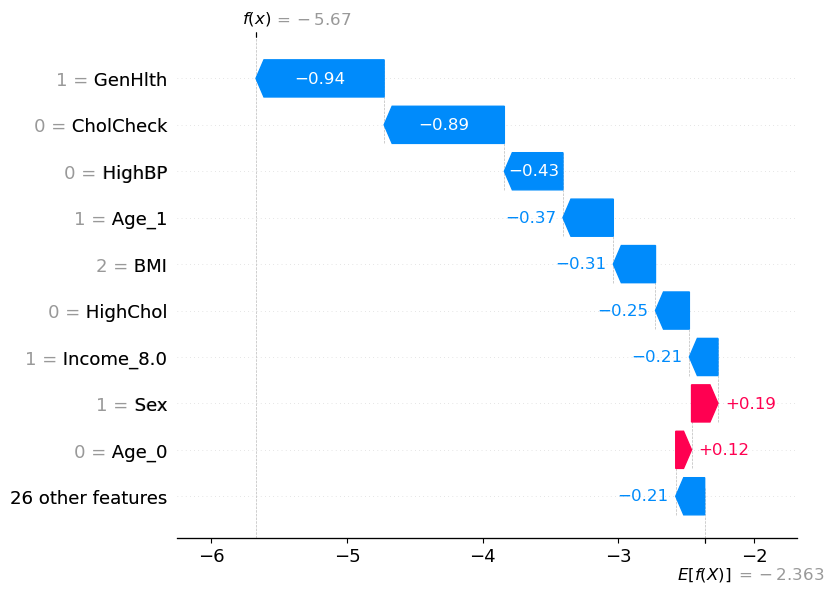

In [26]:
print(model.predict_proba(X_sample)[detect_patient_with_negative_prediction()])
shap.waterfall_plot(shap_values[detect_patient_with_negative_prediction()])

This is the interpretation of features for patient X that was predicted to have low risk of diabates

Now let's see the trend that the most important feature (general health) has on the model's predictions

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.75 will be ignored. Curre

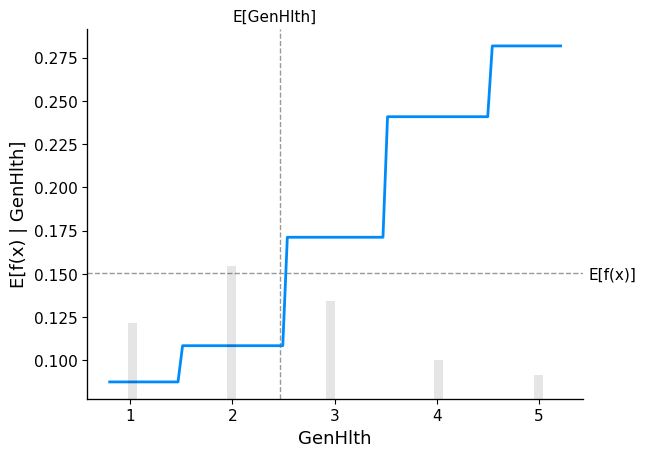

In [27]:
def model_lr_proba(x):
    return model.predict_proba(x)[:, 1]



fig,ax = shap.partial_dependence_plot(
    "GenHlth", model_lr_proba, X_sample, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

General health feature has a scale 1-5 where 1=excellent and 5=poor. In conclusion the worse the general health the higher the risk of dabetes.